In [24]:
%matplotlib inline
import os
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import pickle
import scipy
import cv2
from PIL import ImageOps
import pydot

In [25]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [26]:
img_width, img_height = 200, 200
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 8
epochs = 10

data_size = 5117

In [27]:
def load_dataset():
    path_to_file = "Selfie-dataset/selfie_dataset.txt"
    df = pd.read_csv(path_to_file, sep=" ", header=None, encoding='utf-8')
    print(type(df))
    df.columns = ["image_name","popularity_score","partial_faces","is_female","baby","child","teenager","youth","middle_age","senior","white","black","asian","oval_face","round_face","heart_face","smiling","mouth_open","frowning","wearing_glasses","wearing_sunglasses","wearing_lipstick","tongue_out","duck_face","black_hair","blond_hair","brown_hair","red_hair","curly_hair","straight_hair","braid_hair","showing_cellphone","using_earphone","using_mirror","braces","wearing_hat","harsh_lighting","dim_lighting"]
    df = df[["image_name", "popularity_score", "is_female", "baby", "child", "teenager", "youth", "middle_age","senior"]]
    df_updated = pd.DataFrame()
    limit = 1000

    # df_updated = df_updated.append(df[df.is_female == 1][:limit])
    # df.drop(df.index[df.is_female == 1].tolist())
#     print(df.shape)
#     print(df_updated.shape)

    babies_to_write = []


    # df_updated = df_updated.append(df[df.baby == -1][:limit])
    # df.drop(df.index[df.baby ==-1].tolist())
    df_updated = df_updated.append(df[df.baby== 1][:limit])
    df.drop(df.index[df.baby == 1].tolist())


#     print(df_updated.shape)


    # df_updated = df_updated.append(df[df.child == -1][:limit])
    # df.drop(df.index[df.child ==-1].tolist())
    df_updated = df_updated.append(df[df.child== 1][:limit])
    df.drop(df.index[df.child == 1].tolist())


#     print(df_updated.shape)

    # df_updated = df_updated.append(df[df.teenager == -1][:limit])
    # df.drop(df.index[df.teenager ==-1].tolist())
    df_updated = df_updated.append(df[df.teenager== 1][:limit])
    df.drop(df.index[df.teenager == 1].tolist())


#     print(df_updated.shape)


    # df_updated = df_updated.append(df[df.youth == -1][:limit])
    # df.drop(df.index[df.youth ==-1].tolist())
    df_updated = df_updated.append(df[df.youth== 1][:limit])
    df.drop(df.index[df.youth == 1].tolist())


#     print(df_updated.shape)

    # df_updated = df_updated.append(df[df.middle_age == -1][:limit])
    # df.drop(df.index[df.middle_age ==-1].tolist())
    df_updated = df_updated.append(df[df.middle_age== 1][:limit])
    df.drop(df.index[df.middle_age == 1].tolist())


#     print(df_updated.shape)

    # df_updated = df_updated.append(df[df.senior == -1][:limit])
    # df.drop(df.index[df.senior ==-1].tolist())
    df_updated = df_updated.append(df[df.senior== 1][:limit])
    df.drop(df.index[df.senior == 1].tolist())
    print()

    return df_updated


In [28]:
data = load_dataset()

<class 'pandas.core.frame.DataFrame'>



In [7]:
data.head()

,image_name,popularity_score,is_female,baby,child,teenager,youth,middle_age,senior
111,10004346_477351965700359_810393995_a,3.447,-1,1,-1,-1,-1,-1,-1
1500,10004164_681799591879909_1358216422_a,4.642,0,1,-1,-1,-1,-1,-1
1501,10004346_477351965700359_810393995_a,3.447,-1,1,-1,-1,-1,-1,-1
1502,10009169_670633286317131_18435237_a,3.910,0,1,-1,-1,-1,-1,-1
1503,10009183_265598693620440_898180906_a,3.255,0,1,-1,-1,-1,-1,-1


In [29]:
# remove female = 0
data = data.drop(data[data.is_female == 0].index)

In [30]:
data=data.replace({'is_female': {-1: 0}})
data=data.replace({'baby': {-1: 0}})
data=data.replace({'child': {-1: 0}})
data=data.replace({'teenager': {-1: 0}})
data=data.replace({'youth': {-1: 0}})
data=data.replace({'middle_age': {-1: 0}})
data=data.replace({'senior': {-1: 0}})

In [31]:
data.head()

,image_name,popularity_score,is_female,baby,child,teenager,youth,middle_age,senior
111,10004346_477351965700359_810393995_a,3.447,0,1,0,0,0,0,0
1501,10004346_477351965700359_810393995_a,3.447,0,1,0,0,0,0,0
1504,10009339_539945986123146_762803808_a,3.810,1,1,0,0,0,0,0
1505,10009877_469288789865939_1059049450_a,4.497,0,1,0,0,0,0,0
1506,10009889_1411061865825272_1536531170_a,4.200,0,1,0,0,0,0,0


In [11]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(data['image_name'][:data_size], data.iloc[:, 1:][:data_size], test_size=0.15, random_state=seed)

In [12]:
def  get_im_PIL(filename):
    img_pil = Image.open(filename)
    img_pil = img_pil.resize((img_width, img_height), Image.ANTIALIAS)
    img_pil = ImageOps.box_blur(img_pil, radius=1)
    img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    return np.asarray(img_pil)

def load_train(file=False, name=""):
    '''
    read the image and return the data
    main folder shoud be split into data and code
    put the images in Selfie-dataset/images
    '''
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()
    folders = ["Selfie-dataset/images"]
#     print('Read train images')
    if(file):
        for fld in folders:
            files=[]
            files.append(os.path.join(fld, name+'.jpg'))
            for fl in files:
                flbase = os.path.basename(fl)
                img = get_im_PIL(fl)
                X_train.append(img)
                X_train_id.append(flbase)
#         print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
        return X_train
    else:
        for fld in folders:
            path = os.path.join('..',fld, '*.jpg')
            files = glob.glob(path)
            for fl in files[:100]:
                flbase = os.path.basename(fl)
                img = get_im_cv2(fl)
                X_train.append(img)
                X_train_id.append(flbase)

#         print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
        return X_train


def read_and_normalize_train_data(file=False,name=""):
    '''
    read the image or the whole dataset
    return - normalised numpy array 
    '''
    train_data = load_train(file,name)

#     print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)

#     print('Reshape...')
#     print(train_data.shape)
#     train_data = train_data.transpose((0, 3, 1, 2))

#     print('Convert to float...')
    train_data = train_data.astype('float32')
    train_data = train_data / 255

#     print('Train shape:', train_data.shape)
    return train_data

In [13]:
def get_data(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    data_list = []
    output1 = [] # popularity_score
    output2 = [] # gender
    output3 = [] # age
    for i in range(len(X)):
        #print(x)
        data_list.append((read_and_normalize_train_data(file=True, name=X[i])[0]))
        #print((read_and_normalize_train_data(file=True, name=x)[0]).shape)
        output1.append(Y[i][0])
        output2.append(Y[i][1])
        output3.append(Y[i][2:])
    output = [np.array(output1), np.array(output2), np.array(output3)]
    return np.array(data_list), output

In [13]:
X_train, y_train = get_data(X_train, y_train)

In [14]:
X_test, y_test = get_data(X_test, y_test)

In [15]:
def no_of_layers(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name)

In [32]:
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task lossmodel.summary()
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [33]:
def modify_resnet(model):
    for layer in model.layers[:30]:
        layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    
    regression_head = Dense(1)(x)
    gender_head = Dense(1, activation="sigmoid")(x)
    classification_head = Dense(6, activation="softmax")(x)

    # creating the final model 
    model_final = Model(input = model.input, output = [regression_head, gender_head, classification_head])

    # compile the model 
    model_final.compile(loss = ['mean_squared_error', multitask_loss, 'categorical_crossentropy'], optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    return model_final

# Train -- model with regression and classification heads

In [34]:
model = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200, 200, 3), pooling=None, classes=1000)
model = modify_resnet(model)

/home/shahidikram0701/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [19]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.10, verbose=1)

Train on 3575 samples, validate on 398 samples
Epoch 1/10
3575/3575 [==============================] - 336s 94ms/step - loss: 3.1520 - dense_3_loss: 0.7718 - dense_4_loss: 0.6418 - dense_5_loss: 1.7384 - dense_3_acc: 2.7972e-04 - dense_4_acc: 0.6283 - dense_5_acc: 0.2386 - val_loss: 158.2797 - val_dense_3_loss: 154.3013 - val_dense_4_loss: 0.7202 - val_dense_5_loss: 3.2582 - val_dense_3_acc: 0.0000e+00 - val_dense_4_acc: 0.5050 - val_dense_5_acc: 0.1960
Epoch 2/10
3575/3575 [==============================] - 332s 93ms/step - loss: 2.4114 - dense_3_loss: 0.3279 - dense_4_loss: 0.5185 - dense_5_loss: 1.5650 - dense_3_acc: 2.7972e-04 - dense_4_acc: 0.7569 - dense_5_acc: 0.3499 - val_loss: 3.6661 - val_dense_3_loss: 1.5932 - val_dense_4_loss: 0.4932 - val_dense_5_loss: 1.5797 - val_dense_3_acc: 0.0000e+00 - val_dense_4_acc: 0.7688 - val_dense_5_acc: 0.3216
Epoch 3/10
3575/3575 [==============================] - 334s 93ms/step - loss: 2.1125 - dense_3_loss: 0.2634 - dense_4_loss: 0.4260 - d

In [35]:
model.load_weights("task1_weights_augmented_2.h5")

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

# TEST

In [19]:
scores = model.evaluate(X_test, y_test)

702/702 [==============================] - 25s 35ms/step


In [20]:
print("*" * 75)
print("loss for rating\t\t\t ", scores[1])
print("accuracy for age gender\t\t ", scores[-2] * 100)
print("accuracy for age classification\t ", scores[-1] * 100)
print("*" * 75)

***************************************************************************
loss for rating			  0.4464027030855163
accuracy for age gender		  91.73789175487312
accuracy for age classification	  69.23076923076923
***************************************************************************


# PREDICT

In [39]:
data[data["teenager"] == 1]

,image_name,popularity_score,is_female,baby,child,teenager,youth,middle_age,senior
1517,10011379_380114822126806_43616921_a,3.614,0,1,0,1,0,0,0
7356,10011379_380114822126806_43616921_a0,3.614,0,1,0,1,0,0,0
7357,10011379_380114822126806_43616921_a1,3.614,0,1,0,1,0,0,0
7358,10011379_380114822126806_43616921_a2,3.614,0,1,0,1,0,0,0
0,024696bead0c11e389d50ec42b3b1b1c_6,4.169,0,0,0,1,0,0,0
3,07f71a82232111e29ade22000a1f9bd0_6,3.471,0,0,0,1,0,0,0
43,10004186_1388533111427258_618096221_a,2.913,0,0,0,1,0,0,0
49,10004221_1381722998747799_1369134392_a,4.290,0,0,0,1,0,0,0
55,10004245_1387614478185974_2129771701_a,3.564,0,0,0,1,0,0,0
58,10004255_1485189365043306_1625114994_a,5.902,0,0,0,1,0,0,0


In [36]:
def yes_or_no(val):
    if(val < 0.2):
        return "no"
    return "yes"

In [37]:
def predict(model, to_predict):
    
    plt.imshow(Image.open("Selfie-dataset/images/" + to_predict + ".jpg").resize((img_width, img_height), Image.ANTIALIAS))
    
    X_predict = read_and_normalize_train_data(True, to_predict)

#     print(X_predict.shape)
    res = model.predict(X_predict)
    
#     print(res)
    print("Image Rating\t", res[0][0][0])
    
#     print("\n\n")
    
    print("female: \t", yes_or_no(res[1][0][0]))
    print()
    print()
    age = ["baby", "child", "teenager", "youth", "middle_age", "senior"]
    print(age[np.argmax(res[2])])
#     print("baby: \t\t", yes_or_no(res[1][0][1]))
#     print("child: \t\t", yes_or_no(res[1][0][2]))
#     print("teenager:\t", yes_or_no(res[1][0][3]))
#     print("youth: \t\t", yes_or_no(res[1][0][4]))
#     print("middle_age: \t", yes_or_no(res[1][0][5]))
#     print("senior: \t", yes_or_no(res[1][0][6]))
    
    

Image Rating	 3.9797542
female: 	 no


senior


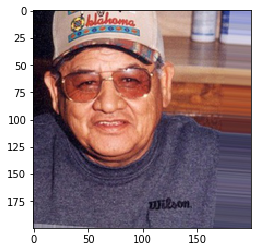

In [24]:
predict(model, "925831_695720860492146_2023280445_a12")

Image Rating	 3.6265216
female: 	 yes


middle_age


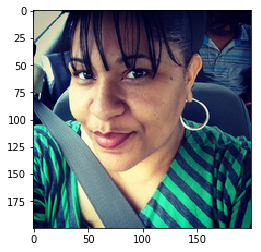

In [25]:
predict(model, "10012458_298952203605870_491373422_a")

Image Rating	 4.4858375
female: 	 yes


child


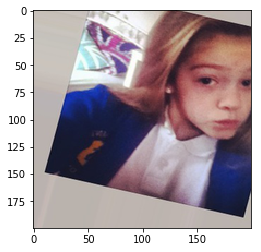

In [26]:
predict(model, "10175241_1408781076058160_1032737994_a0")

Image Rating	 2.8381429
female: 	 no


baby


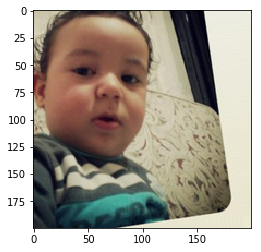

In [27]:
predict(model, "10004346_477351965700359_810393995_a0")

Image Rating	 3.402364
female: 	 no


teenager


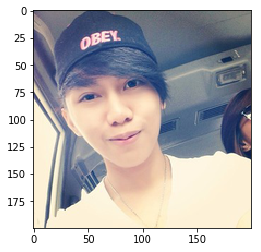

In [28]:
predict(model, "024696bead0c11e389d50ec42b3b1b1c_6")

# Classification of us Team members 

Image Rating	 3.9067972
female: 	 no


senior


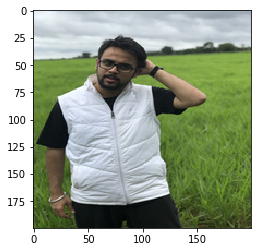

In [29]:
predict(model, "nishant")

Image Rating	 3.1522615
female: 	 no


middle_age


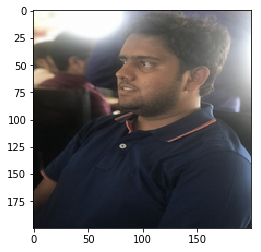

In [30]:
predict(model, "sanky")

Image Rating	 4.6829886
female: 	 no


youth


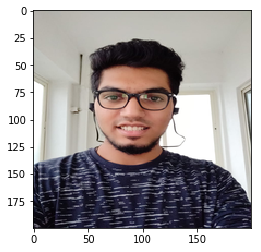

In [31]:
predict(model, "shahid1")

Image Rating	 4.374714
female: 	 no


youth


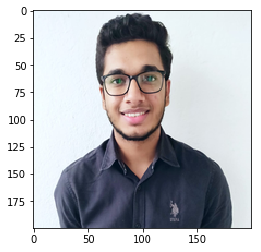

In [32]:
predict(model, "sumanth1")

Image Rating	 4.0214005
female: 	 no


child


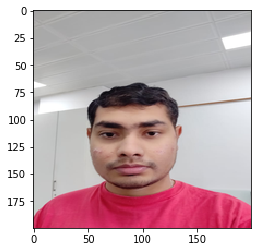

In [34]:
predict(model, "roy")

Image Rating	 4.8623652
female: 	 yes


child


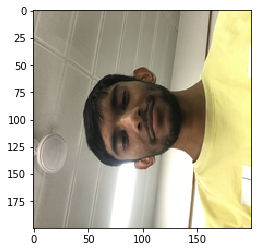

In [38]:
predict(model, "shakti")

# MODEL SAVE

In [96]:
model.save_weights("task1_weights_augmented.h5")

# PLOT LOSS

dict_keys(['val_loss', 'val_dense_3_loss', 'val_dense_4_loss', 'val_dense_5_loss', 'val_dense_3_acc', 'val_dense_4_acc', 'val_dense_5_acc', 'loss', 'dense_3_loss', 'dense_4_loss', 'dense_5_loss', 'dense_3_acc', 'dense_4_acc', 'dense_5_acc'])


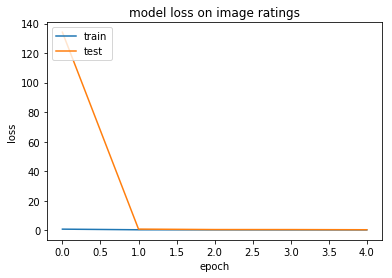

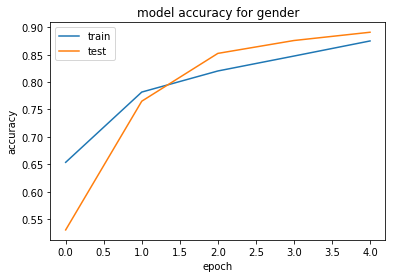

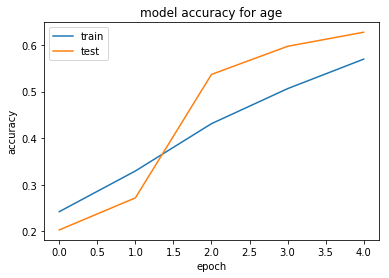

In [46]:
history = model.history
print(history.history.keys())

# Rating
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['val_dense_3_loss'])
plt.title('model loss on image ratings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Gender
plt.plot(history.history['dense_4_acc'])
plt.plot(history.history['val_dense_4_acc'])
plt.title('model accuracy for gender')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#Age
plt.plot(history.history['dense_5_acc'])
plt.plot(history.history['val_dense_5_acc'])
plt.title('model accuracy for age')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()





# Use attrs and image and give rating

In [23]:
# seed = 123
# X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(data['image_name'][:data_size], data.iloc[:, 1:][:data_size], test_size=0.15, random_state=seed)
# X_train_3, y_train_3 = get_data(X_train_3, y_train_3)
# X_test_3, y_test_3 = get_data(X_test_3, y_test_3)

In [24]:
# model3 = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200, 200, 3), pooling=None, classes=1000)
# model3 = modify_resnet(model3, 36)

In [25]:
# y_train_3[0] = np.array(y_train_3[0])
# y_train_3[1] = np.array(y_train_3[1])

# y_test_3[0] = np.array(y_test_3[0])
# y_test_3[1] = np.array(y_test_3[1])

In [26]:
# history3 = model3.fit(X_train_3, y_train_3, epochs=epochs, batch_size=batch_size, validation_split=0.20, verbose=1)

In [33]:
predicted_attrs = model.predict(X_train)

In [35]:
predicted_attrs[2].shape

(3973, 6)

In [36]:
def modify_resnet2(model):
    for layer in model.layers[:30]:
        layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    auxiliary_input_gender = Input(shape=(1,), name = "auxiliary_input_gender")
    auxiliary_input_age = Input(shape=(6,), name = "auxiliary_input_age")
    x = concatenate([x, auxiliary_input_gender, auxiliary_input_age])
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    
    
    regression_head = Dense(1)(x)
    

    # creating the final model 
    model_final = Model(input = [model.input, auxiliary_input_gender, auxiliary_input_age], output = regression_head)

    # compile the model 
    model_final.compile(loss = 'mean_squared_error', optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    return model_final

In [37]:
model2 = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200, 200, 3), pooling=None, classes=1000)
model2 = modify_resnet2(model2)

/home/shahidikram0701/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [38]:
model2.fit([X_train, predicted_attrs[1], predicted_attrs[2]], y_train[0], epochs=5, batch_size=batch_size, validation_split=0.20, verbose = 1)

Train on 3178 samples, validate on 795 samples
Epoch 1/5
3178/3178 [==============================] - 306s 96ms/step - loss: 0.7939 - acc: 3.1466e-04 - val_loss: 23.5684 - val_acc: 0.0000e+00
Epoch 2/5
3178/3178 [==============================] - 306s 96ms/step - loss: 0.3194 - acc: 3.1466e-04 - val_loss: 0.6602 - val_acc: 0.0000e+00
Epoch 3/5
3178/3178 [==============================] - 314s 99ms/step - loss: 0.2533 - acc: 3.1466e-04 - val_loss: 0.5012 - val_acc: 0.0000e+00
Epoch 4/5
3178/3178 [==============================] - 310s 97ms/step - loss: 0.2199 - acc: 3.1466e-04 - val_loss: 0.6365 - val_acc: 0.0000e+00
Epoch 5/5
3178/3178 [==============================] - 311s 98ms/step - loss: 0.1792 - acc: 3.1466e-04 - val_loss: 0.5715 - val_acc: 0.0000e+00


In [34]:
model2.load_weights("4b.weights.h5")

# Save model

In [39]:
model2.save_weights("4b.weights_2.h5")

In [40]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

# TEST

In [42]:
predicted_attrs_test = model.predict(X_test)

In [43]:
scores2 = model2.evaluate([X_test, predicted_attrs_test[1], predicted_attrs_test[2]], y_test[0])

702/702 [==============================] - 23s 32ms/step


In [44]:
print("loss: ", scores2[0])

loss:  0.5246079049558721


# Plot of Loss

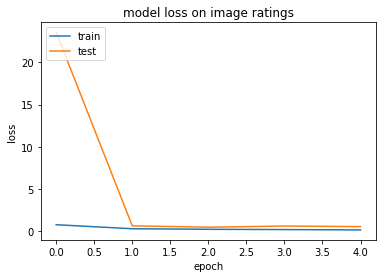

In [41]:
history2 = model2.history
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss on image ratings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

In [47]:
def predict2(model, model2, to_predict):
    
    plt.imshow(Image.open("Selfie-dataset/images/" + to_predict + ".jpg"))
    
    X_predict = read_and_normalize_train_data(True, to_predict)
    
    res = model.predict(X_predict)
    
    res2 = model2.predict([X_predict, res[1], res[2]])
    
#     print(res2)

#     print("actual rating\t\t\t\t\t\t", (data[data["image_name"] == to_predict])["popularity_score"].iloc[0] )
#     print()
    print("Image Rating of model with 2 output heads\t\t", res[0][0][0])
    print()
    print("Image Rating of new model\t\t\t\t", res2[0][0])
    
    print("\n\n")
    
    
    

actual rating						 4.169

Image Rating of model with 2 output heads		 3.402364

Image Rating of new model				 3.548894





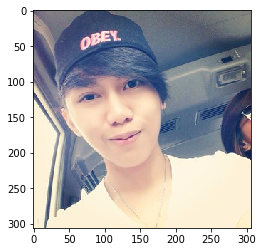

In [46]:
predict2(model, model2, "024696bead0c11e389d50ec42b3b1b1c_6")

In [48]:
def score(model, model2, image):
    img = Image.open(image)
    
    train_data = get_im_PIL(filename=image)
    train_data = [train_data]
    train_data = np.array(train_data, dtype=np.uint8)

    train_data = train_data.astype('float32')
    train_data = train_data / 255

    X_predict = train_data
    
    res = model.predict(X_predict)
    
    
    res2 = model2.predict([X_predict, res[1], res[2]])
    
#     print(res2)

#     print("actual rating\t\t\t\t\t\t", (data[data["image_name"] == to_predict])["popularity_score"].iloc[0] )
#     print()
#     print("Image Rating of model with 2 output heads\t\t", res[0][0][0])
#     print()
    
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf", 70, encoding="unic")
    # font = ImageFont.truetype(<font-file>, <font-size>)
#     font = ImageFont.truetype("sans-serif.ttf", 16)
    # draw.text((x, y),"Sample Text",(r,g,b))
    draw.text((0, 0), str(res2[0][0]), "black",font=font)
    
#     print("Image Rating\t\t\t\t", res2[0][0])
    
#     plt.imshow(img)
    filename = image.split("/")
    filename[0] += "_result"
    
    img.save("/".join(filename))
#     print("\n")
    

# Testing on a random dataset from Instagram

In [49]:

for i in range(1, 33):
    score(model, model2, "insta/ (" + str(i) + ").jpg") 

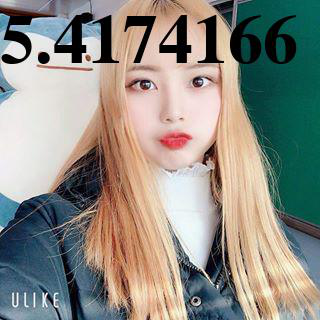

In [50]:
Image.open("insta_result/ (1).jpg")

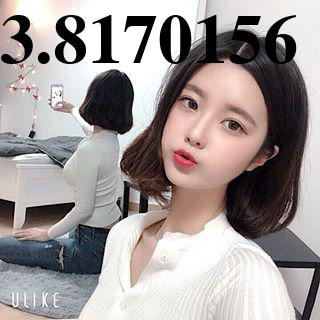

In [51]:
Image.open("insta_result/ (15).jpg")

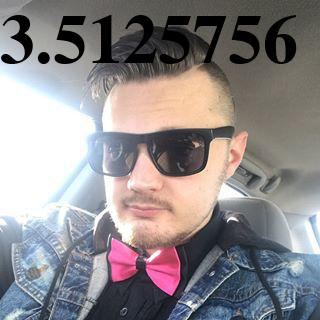

In [52]:
Image.open("insta_result/ (5).jpg")

# Rating us Team memebers :P

Image Rating of model with 2 output heads		 3.1522615

Image Rating of new model				 3.2650127





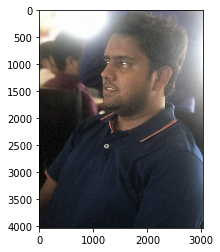

In [53]:
predict2(model, model2, "sanky")

Image Rating of model with 2 output heads		 3.9067972

Image Rating of new model				 3.724429





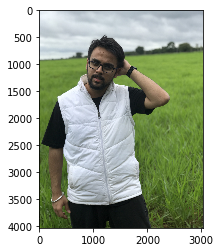

In [54]:
predict2(model, model2, "nishant")

Image Rating of model with 2 output heads		 4.6829886

Image Rating of new model				 4.3032904





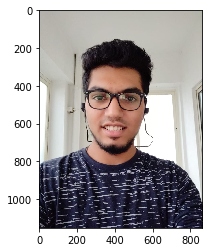

In [55]:
predict2(model, model2, "shahid1")

Image Rating of model with 2 output heads		 4.374714

Image Rating of new model				 4.4964056





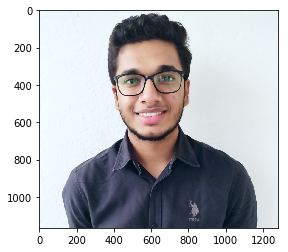

In [56]:
predict2(model, model2, "sumanth1")